# 데이터 전처리
- py-hanspell
- 부산대학교 맞춤법 검사기

### 1. py-hanspell
설치 방법
1. git clone https://github.com/ssut/py-hanspell
2. cd py-hanspell
3. python setup.py install

수정 사항
- py-hanspell을 사용하면 error가 발생. 웹에서 네이버 맞춤법검사기에 접속 -> F12를 누르고 "network"목록에 들어간 후 맞춤법검사기를 아무거나 1번 실행 -> passportKey값을 copy
- py-hanspell/hanspell/spell_checker.py 에서 payload변수에 passportKey값을 추가.
- python setup.py install을 실행한 후, 사용

In [50]:
from hanspell import spell_checker

text = "외않되"

spelled_text = spell_checker.check(text)
if spelled_text.errors > 0:
    print(spelled_text.checked)

왜 안돼


### py-hanspell을 사용해 train data 수정

In [51]:
from tqdm import tqdm
import pandas as pd

In [55]:
train_data = pd.read_csv("../../data/train.csv")

In [57]:
for idx, text in enumerate(tqdm(train_data["text"], desc="py-hanspell")):
    spelled_text = spell_checker.check(text)
    train_data.iloc[idx, 1] = spelled_text.checked

py-hanspell: 100%|██████████| 7000/7000 [03:25<00:00, 34.10it/s]


### 2. 부산대학교 맞춤법 검사기
requests를 사용해 맞춤법 검사기 웹사이트에 request를 보내고 받는 형식으로 사용

In [47]:
import json
import requests

In [19]:
text = "이뤄 뢰구긴 관광개 길보니 한구긔 이배…격차 계소 콱때되나"

In [20]:
response = requests.post('http://164.125.7.61/speller/results', data={'text1': text})
data = response.text.split('data = [', 1)[-1].rsplit('];', 1)[0]
data = json.loads(data)
data["errInfo"]

[{'help': '철자 검사를 해 보니 이 어절은 분석할 수 없으므로 틀린 말로 판단하였습니다.<br/><br/>후보 어절은 이 철자검사/교정기에서 띄어쓰기, 붙여 쓰기, 음절대치와 같은 교정방법에 따라 수정한 결과입니다.<br/><br/>후보 어절 중 선택하시거나 오류 어절을 수정하여 주십시오.<br/><br/>* 단, 사전에 없는 단어이거나 사용자가 올바르다고 판단한 어절에 대해서는 통과하세요!!',
  'errorIdx': 0,
  'correctMethod': 1,
  'start': 3,
  'errMsg': '',
  'end': 6,
  'orgStr': '뢰구긴',
  'candWord': '외국이긴'},
 {'help': '입력 오류입니다.',
  'errorIdx': 1,
  'correctMethod': 2,
  'start': 7,
  'errMsg': '',
  'end': 10,
  'orgStr': '관광개',
  'candWord': '관광객'},
 {'help': '입력 오류입니다.',
  'errorIdx': 2,
  'correctMethod': 2,
  'start': 15,
  'errMsg': '',
  'end': 18,
  'orgStr': '한구긔',
  'candWord': '한국의|한 구의|한도의'},
 {'help': '곱절 이익, 타원형 잔, 귀양살이 위치를 옮김을 뜻하면 쓸 수 있습니다.',
  'errorIdx': 3,
  'correctMethod': 2,
  'start': 19,
  'errMsg': '',
  'end': 21,
  'orgStr': '이배',
  'candWord': '이 배|두 배|곱절 이익|타원형 잔|귀양살이 위치를 옮김'},
 {'help': '입력 오류입니다.',
  'errorIdx': 4,
  'correctMethod': 2,
  'start': 25,
  'errMsg': '',
  'end': 27,
  'orgStr': '계소',
  'candWord': '계속

### 부산대 맞춤법 검사기로 train data수정

In [49]:
from tqdm import tqdm
import pandas as pd
import random
import time
import re

train_data = pd.read_csv("../../data/train.csv")

num_of_error_list = []

for idx, text in enumerate(tqdm(train_data["text"])):
    response = requests.post('http://164.125.7.61/speller/results', data={'text1': text})
    data = response.text.split('data = [', 1)[-1].rsplit('];', 1)[0]
    num_of_error = 0
    
    try:
        data = json.loads(data)
        
        for info in data["errInfo"]:
            # 띄어쓰기 교정이 아닌 교정들만 count
            if info["orgStr"].replace(" ", "") != info["candWord"].split("|")[0].replace(" ", ""):
                num_of_error += 1
            text = re.sub(info["orgStr"], info["candWord"].split("|")[0], text)
        
        train_data.iloc[idx, 1] = text
    except:
        pass
    
    num_of_error_list.append(num_of_error)
    
    if idx % 100 == 0:
        time.sleep(random.uniform(2,4))

100%|██████████| 7000/7000 [40:22<00:00,  2.89it/s]  


In [50]:
preprocessed_data = train_data
preprocessed_data["num error"] = num_of_error_list

In [74]:
# 띄어쓰기 교정은 error로 count되지 않았습니다.
print("error 최대 수 : ", max(preprocessed_data["num error"]))

error 최대 수 :  7


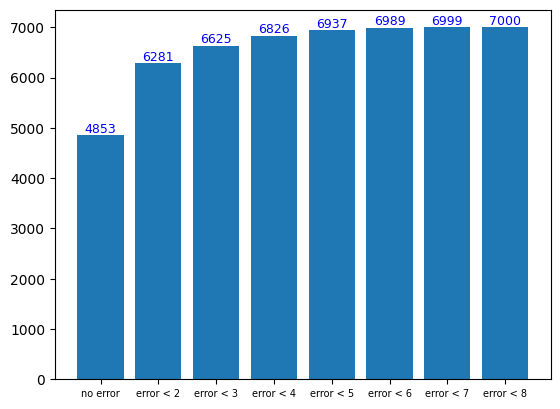

In [75]:
import matplotlib.pyplot as plt

x = ["no error", "error < 2", "error < 3", "error < 4", "error < 5", "error < 6", "error < 7", "error < 8"]
y = [len(preprocessed_data[preprocessed_data["num error"] < 1]), len(preprocessed_data[preprocessed_data["num error"] < 2]),
     len(preprocessed_data[preprocessed_data["num error"] < 3]), len(preprocessed_data[preprocessed_data["num error"] < 4]),
     len(preprocessed_data[preprocessed_data["num error"] < 5]), len(preprocessed_data[preprocessed_data["num error"] < 6]),
     len(preprocessed_data[preprocessed_data["num error"] < 7]), len(preprocessed_data[preprocessed_data["num error"] < 8])]

plt.bar(x, y)
plt.xticks(size=7)
for i, v in enumerate(x):
    plt.text(v, y[i], y[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='blue',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)

plt.show()

In [57]:
preprocessed_data_all = preprocessed_data
preprocessed_data_less2 = preprocessed_data[preprocessed_data["num error"] < 2]
preprocessed_data_less3 = preprocessed_data[preprocessed_data["num error"] < 3]
preprocessed_data_less4 = preprocessed_data[preprocessed_data["num error"] < 4]
preprocessed_data_less5 = preprocessed_data[preprocessed_data["num error"] < 5]
preprocessed_data_less6 = preprocessed_data[preprocessed_data["num error"] < 6]

In [58]:
preprocessed_data_all.to_csv("../../data/train_spelled_all.csv", index=False)
preprocessed_data_less2.to_csv("../../data/train_spelled_less2.csv", index=False)
preprocessed_data_less3.to_csv("../../data/train_spelled_less3.csv", index=False)
preprocessed_data_less4.to_csv("../../data/train_spelled_less4.csv", index=False)
preprocessed_data_less5.to_csv("../../data/train_spelled_less5.csv", index=False)
preprocessed_data_less6.to_csv("../../data/train_spelled_less6.csv", index=False)